### Import

In [70]:
import os
import re  
import fnmatch 
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

### Path

In [2]:
parquet_dir = './Data/parquet/'

### Read Population Labels

In [3]:
pop_labels = pd.read_csv(parquet_dir + 'igsr_samples.tsv', sep='\t')
pop_labels.head(3)

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,Data collections
0,HG00271,male,SAME123417,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,HG00276,female,SAME123424,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,HG00288,female,SAME1839246,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


### Read Data

In [4]:
df = pd.read_parquet(parquet_dir + "Final_Data.parquet", engine='pyarrow')
result_df = df.transpose()
result_df.head(3)

,rs12124819,rs6681049,rs4970383,rs4475691,rs7537756,rs3748597,rs28391282,rs2340592,rs1891910,rs3128117,...,rs739365,rs5770992,rs2040487,rs9628187,rs6010063,rs10451,rs715586,rs8137951,rs2301584,rs3810648
Person_ID,,,,,,,,,,,,,,,,,,,,,
HG00096,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
HG00097,0.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00099,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Preparing Population Codes

In [5]:
pop_labels = pop_labels[pop_labels['Sample name'].isin(result_df.index)]
pop_labels = pop_labels[['Sample name', 'Population code']]
pop_labels.rename(columns={"Sample name": "Person_ID", "Population code": "labels"}, inplace=True)
pop_labels.loc[pop_labels.labels == 'IBS,MSL', 'labels'] = 'IBS'
pop_labels.head(3)

,Person_ID,labels
0,HG00271,FIN
1,HG00276,FIN
2,HG00288,FIN


In [72]:
def plot_label_distribution(df):

    all_labels = df['labels'].str.split(',').sum()
    label_counts = Counter(all_labels)
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count']).sort_values('Count', ascending=True)

    plt.figure(figsize=(18, 6))
    plt.bar(label_df['Label'], label_df['Count'], color='skyblue')
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Labels', fontsize=12)
    plt.title('Distribution of Labels in Dataset', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout() 
    plt.show()

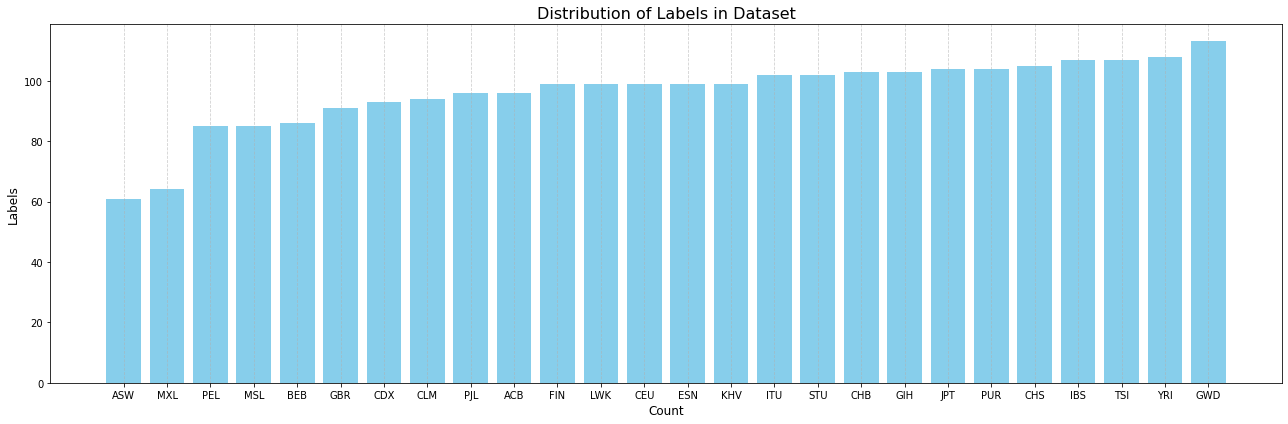

In [73]:
plot_label_distribution(pop_labels)

### Principal Component Analysis (PCA)

In [6]:
def apply_pca(train_df, test_df, n_components=None, explained_variance=None):

    if n_components is not None:
        pca = PCA(n_components=n_components, random_state=42)
    elif explained_variance is not None:
        pca = PCA(n_components=explained_variance, random_state=42)
    else:
        pca = PCA(random_state=42)
    
    principal_components_train = pca.fit_transform(train_df)
    principal_components_test = pca.transform(test_df)
    
    col_names = [f'PC{i+1}' for i in range(principal_components_train.shape[1])]
    
    pca_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    pca_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return pca_train_df, pca_test_df

### Singular Value Decomposition (SVD)

In [7]:
def apply_svd_numpy(df, n_components=100):

    centered_data = df - df.mean()
    
    U, s, Vt = np.linalg.svd(centered_data, full_matrices=False)  
    
    U_reduced  = U[:, :n_components]
    s_reduced  = s[:n_components]
    Vt_reduced = Vt[:n_components, :]

    reduced_data = np.dot(U_reduced, np.diag(s_reduced))
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    svd_df = pd.DataFrame(data=reduced_data, columns=col_names, index= df.index)
    
    return svd_df

In [8]:
def apply_svd_sklearn(train_df, test_df, n_components=100):

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    
    principal_components_train = svd.fit_transform(train_df)
    principal_components_test  = svd.transform(test_df)
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    
    svd_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    svd_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return svd_train_df, svd_test_df

### Random Forest 

In [9]:
def apply_rf_feature_selection(train_df, test_df, labels_df, num_features=None, importance_threshold=None):
    
    merged_df = train_df.merge(labels_df, left_index=True, right_on='Person_ID', how='left')
    
    data = merged_df.drop(columns=['Person_ID', 'labels'])
    labels = merged_df['labels']

    rf = RandomForestClassifier(random_state=42)
    rf.fit(data, labels)

    feature_importances = rf.feature_importances_

    if importance_threshold is not None:
        features_to_keep = train_df.columns[feature_importances >= importance_threshold]
    elif num_features is not None:
        sorted_features = train_df.columns[np.argsort(-feature_importances)]
        features_to_keep = sorted_features[:num_features]
    else:
        features_to_keep = train_df.columns

    rf_train_df = train_df[features_to_keep]
    rf_test_df  = test_df[features_to_keep]
    
    return rf_train_df, rf_test_df

### Normalization

In [10]:
def Normalizing(train_df, test_df):
    
    norm = train_df.columns
    
    train_val = train_df[norm]
    test_val  = test_df[norm]

    scaler = MinMaxScaler().fit(train_val.values)

    train_normalized = scaler.transform(train_val.values)
    test_normalized  = scaler.transform(test_val.values)

    train_df[norm] = train_normalized
    test_df[norm]  = test_normalized

    train_df = train_df.round(3)
    test_df  = test_df.round(3)
    
    return train_df, test_df

### Adding Label

In [11]:
def adding_label(train_df, test_df, labels_df, label_encoder):
    
    train_df = train_df.reset_index()
    test_df  = test_df.reset_index()
    
    train_df = train_df.merge(labels_df, on='Person_ID', how='left')
    test_df  = test_df.merge(labels_df , on='Person_ID', how='left')
    
    train_df['labels'] = label_encoder.transform(train_df['labels'])
    test_df['labels']  = label_encoder.transform(test_df['labels'])
    
    return train_df, test_df

### Apply Model

In [12]:
def apply_model(train_df, test_df, number_classes):
    
    X_train = train_df.drop(columns=['Person_ID', 'labels'])
    X_test  = test_df.drop(columns=[ 'Person_ID', 'labels'])
    y_train = train_df['labels']
    y_test  = test_df['labels']

    lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
    lr_model.fit(X_train, y_train)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train)

    lr_probabilities  = lr_model.predict_proba(X_test)
    xgb_probabilities = xgb_model.predict_proba(X_test)

    lr_results  = pd.DataFrame(lr_probabilities , columns=[f'Prob_Class_{i}' for i in range(0, number_classes)])
    xgb_results = pd.DataFrame(xgb_probabilities, columns=[f'Prob_Class_{i}' for i in range(0, number_classes)])

    lr_results['Person_ID']  = test_df['Person_ID'].values
    xgb_results['Person_ID'] = test_df['Person_ID'].values

    lr_results['True_Label'] = y_test.values
    xgb_results['True_Label']= y_test.values

    lr_results  = lr_results[[ 'Person_ID', 'True_Label'] + [f'Prob_Class_{i}' for i in range(0, number_classes)]]
    xgb_results = xgb_results[['Person_ID', 'True_Label'] + [f'Prob_Class_{i}' for i in range(0, number_classes)]]
    
    return lr_results, xgb_results

### Evaluation

In [13]:
def calculate_predicted_class(df, number_classes):
    
    predicted_labels = df[[f'Prob_Class_{i}' for i in range(0, number_classes)]].idxmax(axis=1)

    predicted_labels = predicted_labels.apply(lambda x: int(x.split('_')[-1]))
    true_labels = df['True_Label']
    
    return true_labels, predicted_labels

In [14]:
def calculate_performance_metrics(true_labels, predicted_labels, number_classes):
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
    evaluation_metrics_df = pd.DataFrame({'Class': [label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)], 
                                          'Precision': precision,
                                          'Recall': recall,
                                          'F1-Score': f1_score})

    avg_recall = recall.mean()
    avg_precision= precision.mean()
    avg_f1_score = f1_score.mean()
    evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',
                                                          'Precision': avg_precision,
                                                          'Recall': avg_recall,
                                                          'F1-Score': avg_f1_score}, 
                                                           ignore_index=True)

    return evaluation_metrics_df

In [55]:
def plot_confusion_matrix(true_labels, predicted_labels, number_classes):
    
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)], 
                                                       yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(0, number_classes)])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [48]:
def plot_roc_curve(true_labels, df, number_classes):

    y_true = label_binarize(true_labels, classes=[i for i in range(0, number_classes)])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], df[f'Prob_Class_{i}'])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), df[[f'Prob_Class_{i}' for i in range(0, number_classes)]].values.ravel())    
        
        
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)


#     for i, color in zip(range(n_classes), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.3f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.00])
    plt.ylim([ 0.00, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro and Macro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

### Cross Validation

In [17]:
number_of_components = 10
classes = list(pop_labels.labels.unique())
number_classes = len(classes)

In [18]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [20]:
X = pop_labels.drop(['labels'], axis=1)
y = pop_labels['labels']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
LR_PCA = []
LR_SVD = []
LR_RF  = []

XG_PCA = []
XG_SVD = []
XG_RF  = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    train_data = result_df[result_df.index.isin(X_train.Person_ID)].copy()
    test_data  = result_df[result_df.index.isin(X_test.Person_ID)].copy()
    
    pca_train_df, pca_test_df = apply_pca(train_data, test_data, n_components=number_of_components, explained_variance=None)  
    svd_train_df, svd_test_df = apply_svd_sklearn(train_data, test_data, n_components=number_of_components)
    rf_train_df , rf_test_df  = apply_rf_feature_selection(train_data, test_data, pop_labels, num_features=number_of_components, importance_threshold=None)
    
    pca_train_df, pca_test_df = Normalizing(pca_train_df, pca_test_df)
    svd_train_df, svd_test_df = Normalizing(svd_train_df, svd_test_df)
    rf_train_df , rf_test_df  = Normalizing(rf_train_df , rf_test_df)
    
    pca_train_df, pca_test_df = adding_label(pca_train_df, pca_test_df, pop_labels, label_encoder)
    svd_train_df, svd_test_df = adding_label(svd_train_df, svd_test_df, pop_labels, label_encoder)
    rf_train_df , rf_test_df  = adding_label(rf_train_df , rf_test_df , pop_labels, label_encoder)
    
    lr_results_pca, xgb_results_pca = apply_model(pca_train_df, pca_test_df, number_classes)
    lr_results_svd, xgb_results_svd = apply_model(svd_train_df, svd_test_df, number_classes)
    lr_results_rf , xgb_results_rf  = apply_model(rf_train_df , rf_test_df , number_classes)
    
    LR_PCA.append(lr_results_pca)
    LR_SVD.append(lr_results_svd)
    LR_RF.append( lr_results_rf)
    
    XG_PCA.append(xgb_results_pca)
    XG_SVD.append(xgb_results_svd)
    XG_RF.append( xgb_results_rf)

In [22]:
final_results_LR_PCA = pd.concat(LR_PCA, ignore_index=True)
final_results_LR_SVD = pd.concat(LR_SVD, ignore_index=True)
final_results_LR_RF  = pd.concat(LR_RF , ignore_index=True)

final_results_XG_PCA = pd.concat(XG_PCA, ignore_index=True)
final_results_XG_SVD = pd.concat(XG_SVD, ignore_index=True)
final_results_XG_RF  = pd.concat(XG_RF , ignore_index=True)

In [23]:
labels_LR_PCA, prediction_LR_PCA = calculate_predicted_class(final_results_LR_PCA, number_classes)
labels_LR_SVD, prediction_LR_SVD = calculate_predicted_class(final_results_LR_SVD, number_classes)
labels_LR_RF , prediction_LR_RF  = calculate_predicted_class(final_results_LR_RF , number_classes)

labels_XG_PCA, prediction_XG_PCA = calculate_predicted_class(final_results_XG_PCA, number_classes)
labels_XG_SVD, prediction_XG_SVD = calculate_predicted_class(final_results_XG_SVD, number_classes)
labels_XG_RF , prediction_XG_RF  = calculate_predicted_class(final_results_XG_RF , number_classes)

## LR - PCA

In [24]:
performance_LR_PCA = calculate_performance_metrics(labels_LR_PCA, prediction_LR_PCA, number_classes)
print(performance_LR_PCA)

      Class  Precision    Recall  F1-Score
0       ACB   0.564286  0.822917  0.669492
1       ASW   0.000000  0.000000  0.000000
2       BEB   1.000000  0.232558  0.377358
3       CDX   1.000000  0.215054  0.353982
4       CEU   0.512953  1.000000  0.678082
5       CHB   0.956522  0.640777  0.767442
6       CHS   0.715278  0.980952  0.827309
7       CLM   0.678571  0.808511  0.737864
8       ESN   1.000000  0.010101  0.020000
9       FIN   1.000000  0.979798  0.989796
10      GBR   0.000000  0.000000  0.000000
11      GIH   1.000000  0.660194  0.795322
12      GWD   1.000000  0.964602  0.981982
13      IBS   0.846154  0.925234  0.883929
14      ITU   0.348000  0.852941  0.494318
15      JPT   1.000000  0.990385  0.995169
16      KHV   0.565476  0.959596  0.711610
17      LWK   1.000000  1.000000  1.000000
18      MSL   0.955056  1.000000  0.977011
19      MXL   0.900000  0.140625  0.243243
20      PEL   0.745455  0.964706  0.841026
21      PJL   0.658824  0.583333  0.618785
22      PUR

/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


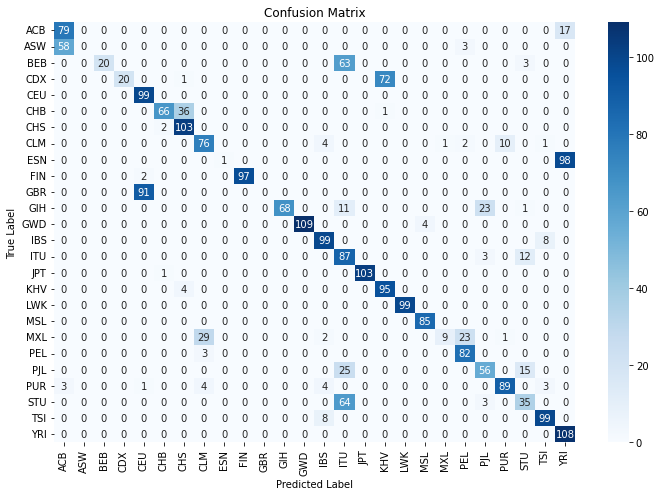

In [56]:
plot_confusion_matrix(labels_LR_PCA, prediction_LR_PCA, number_classes)

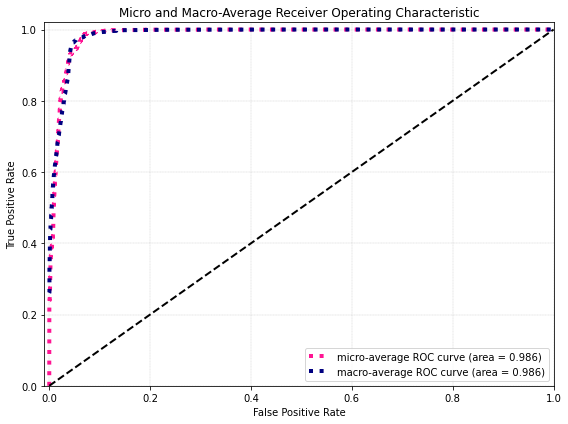

In [49]:
plot_roc_curve(labels_LR_PCA, final_results_LR_PCA, number_classes)

## LR - SVD

In [27]:
performance_LR_SVD = calculate_performance_metrics(labels_LR_SVD, prediction_LR_SVD, number_classes)
print(performance_LR_SVD)

      Class  Precision    Recall  F1-Score
0       ACB   0.562044  0.802083  0.660944
1       ASW   0.000000  0.000000  0.000000
2       BEB   1.000000  0.093023  0.170213
3       CDX   0.984375  0.677419  0.802548
4       CEU   0.507772  0.989899  0.671233
5       CHB   0.936709  0.718447  0.813187
6       CHS   0.748148  0.961905  0.841667
7       CLM   0.686275  0.744681  0.714286
8       ESN   1.000000  0.020202  0.039604
9       FIN   1.000000  0.969697  0.984615
10      GBR   0.000000  0.000000  0.000000
11      GIH   0.985714  0.669903  0.797688
12      GWD   1.000000  0.964602  0.981982
13      IBS   0.820513  0.897196  0.857143
14      ITU   0.338028  0.941176  0.497409
15      JPT   1.000000  0.990385  0.995169
16      KHV   0.756098  0.939394  0.837838
17      LWK   1.000000  1.000000  1.000000
18      MSL   0.955056  1.000000  0.977011
19      MXL   0.769231  0.156250  0.259740
20      PEL   0.745455  0.964706  0.841026
21      PJL   0.657895  0.520833  0.581395
22      PUR

/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


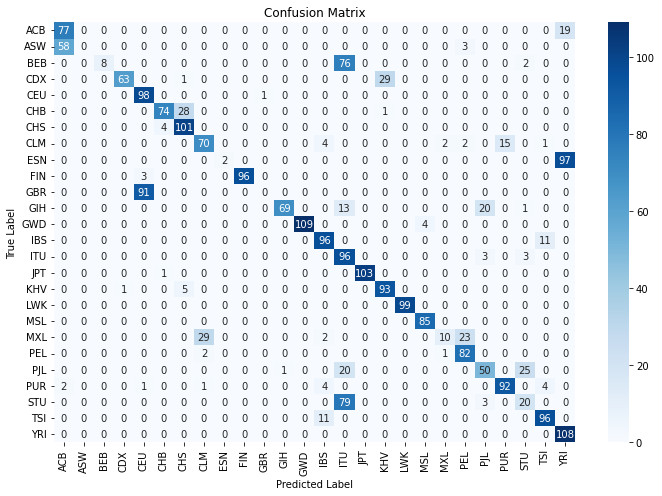

In [57]:
plot_confusion_matrix(labels_LR_SVD, prediction_LR_SVD, number_classes)

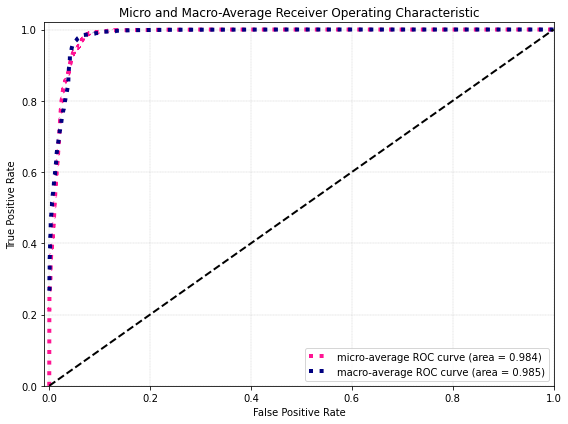

In [50]:
plot_roc_curve(labels_LR_SVD, final_results_LR_SVD, number_classes)

## LR - RF

In [30]:
performance_LR_RF = calculate_performance_metrics(labels_LR_RF , prediction_LR_RF, number_classes)
print(performance_LR_RF)

      Class  Precision    Recall  F1-Score
0       ACB   0.154930  0.114583  0.131737
1       ASW   0.333333  0.016393  0.031250
2       BEB   0.210526  0.046512  0.076190
3       CDX   0.166667  0.129032  0.145455
4       CEU   0.098214  0.111111  0.104265
5       CHB   0.138462  0.087379  0.107143
6       CHS   0.184397  0.247619  0.211382
7       CLM   0.185185  0.053191  0.082645
8       ESN   0.188119  0.191919  0.190000
9       FIN   0.137500  0.111111  0.122905
10      GBR   0.142857  0.021978  0.038095
11      GIH   0.134921  0.165049  0.148472
12      GWD   0.238636  0.371681  0.290657
13      IBS   0.143791  0.205607  0.169231
14      ITU   0.104839  0.127451  0.115044
15      JPT   0.158996  0.365385  0.221574
16      KHV   0.155844  0.121212  0.136364
17      LWK   0.125874  0.181818  0.148760
18      MSL   0.200000  0.058824  0.090909
19      MXL   0.000000  0.000000  0.000000
20      PEL   0.225225  0.294118  0.255102
21      PJL   0.093458  0.104167  0.098522
22      PUR

/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


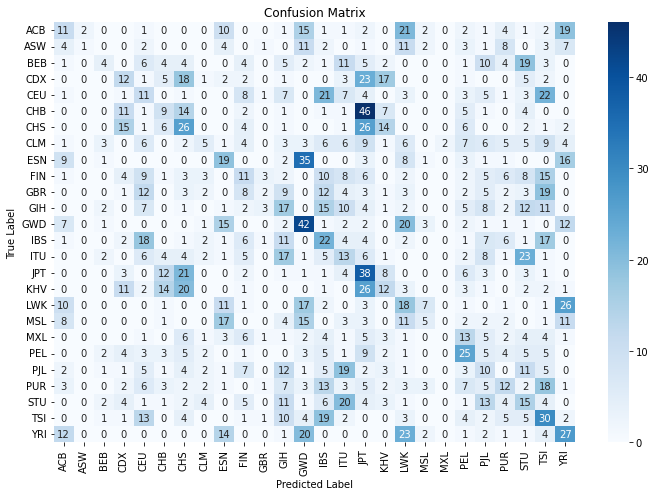

In [58]:
plot_confusion_matrix(labels_LR_RF , prediction_LR_RF, number_classes)

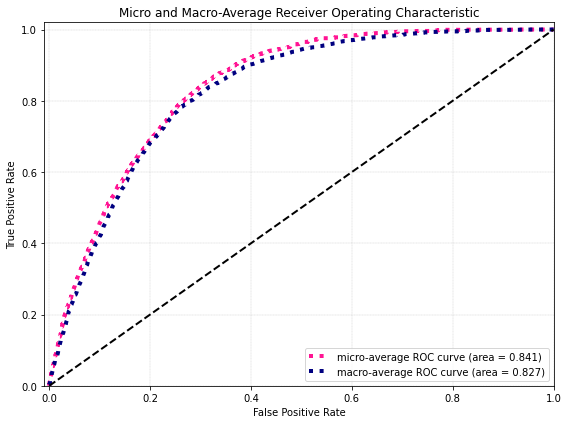

In [51]:
plot_roc_curve(labels_LR_RF, final_results_LR_RF, number_classes)

## XGB - PCA

In [33]:
performance_XG_PCA = calculate_performance_metrics(labels_XG_PCA, prediction_XG_PCA, number_classes)
print(performance_XG_PCA)

      Class  Precision    Recall  F1-Score
0       ACB   0.519231  0.562500  0.540000
1       ASW   0.547170  0.950820  0.694611
2       BEB   0.870588  0.860465  0.865497
3       CDX   0.600000  0.032258  0.061224
4       CEU   0.504505  0.565657  0.533333
5       CHB   0.738739  0.796117  0.766355
6       CHS   0.782178  0.752381  0.766990
7       CLM   0.820513  0.680851  0.744186
8       ESN   0.636364  0.070707  0.127273
9       FIN   1.000000  0.989899  0.994924
10      GBR   0.457831  0.417582  0.436782
11      GIH   0.986486  0.708738  0.824859
12      GWD   0.958333  0.610619  0.745946
13      IBS   0.583333  0.915888  0.712727
14      ITU   0.513514  0.745098  0.608000
15      JPT   1.000000  0.971154  0.985366
16      KHV   0.516129  0.969697  0.673684
17      LWK   1.000000  0.898990  0.946809
18      MSL   0.650794  0.964706  0.777251
19      MXL   0.651685  0.906250  0.758170
20      PEL   0.939024  0.905882  0.922156
21      PJL   0.586207  0.885417  0.705394
22      PUR

/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


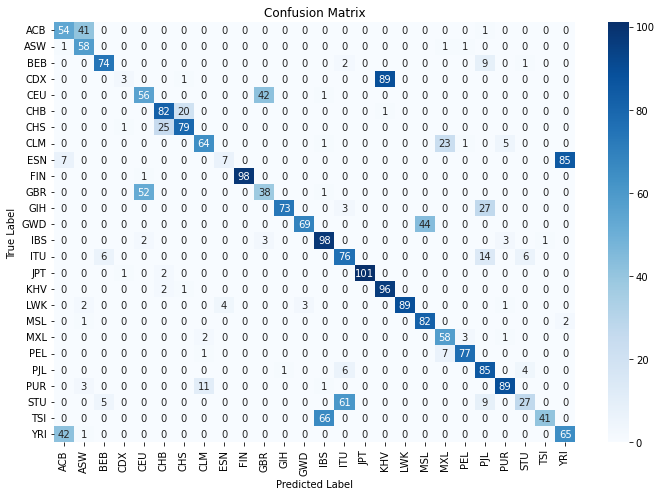

In [59]:
plot_confusion_matrix(labels_XG_PCA, prediction_XG_PCA, number_classes)

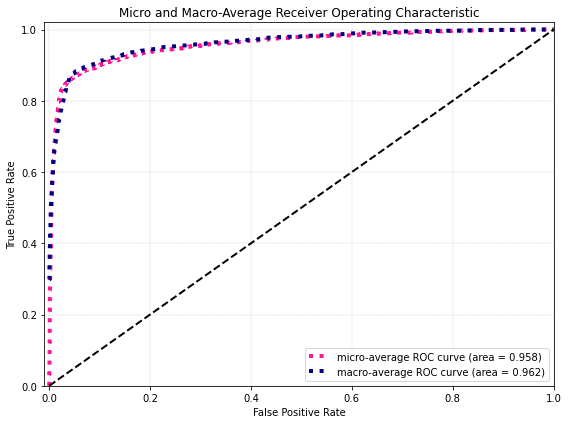

In [52]:
plot_roc_curve(labels_XG_PCA, final_results_XG_PCA, number_classes)

## XGB - SVD 

In [36]:
performance_XG_SVD = calculate_performance_metrics(labels_XG_SVD, prediction_XG_SVD, number_classes)
print(performance_XG_SVD)

      Class  Precision    Recall  F1-Score
0       ACB   0.645161  0.625000  0.634921
1       ASW   0.585859  0.950820  0.725000
2       BEB   0.903614  0.872093  0.887574
3       CDX   0.750000  0.032258  0.061856
4       CEU   0.504274  0.595960  0.546296
5       CHB   0.713043  0.796117  0.752294
6       CHS   0.765306  0.714286  0.738916
7       CLM   0.873239  0.659574  0.751515
8       ESN   0.500000  0.040404  0.074766
9       FIN   1.000000  0.989899  0.994924
10      GBR   0.450000  0.395604  0.421053
11      GIH   0.975000  0.757282  0.852459
12      GWD   1.000000  0.610619  0.758242
13      IBS   0.600000  0.925234  0.727941
14      ITU   0.500000  0.656863  0.567797
15      JPT   1.000000  0.971154  0.985366
16      KHV   0.516129  0.969697  0.673684
17      LWK   1.000000  0.939394  0.968750
18      MSL   0.631148  0.905882  0.743961
19      MXL   0.634409  0.921875  0.751592
20      PEL   0.986842  0.882353  0.931677
21      PJL   0.617188  0.822917  0.705357
22      PUR

/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


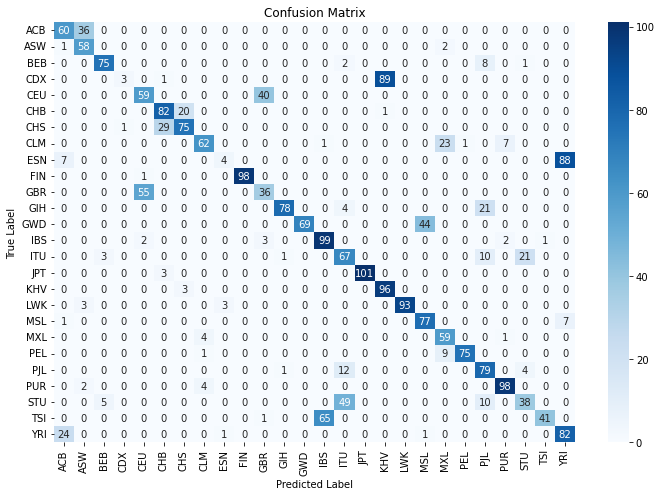

In [60]:
plot_confusion_matrix(labels_XG_SVD, prediction_XG_SVD, number_classes)

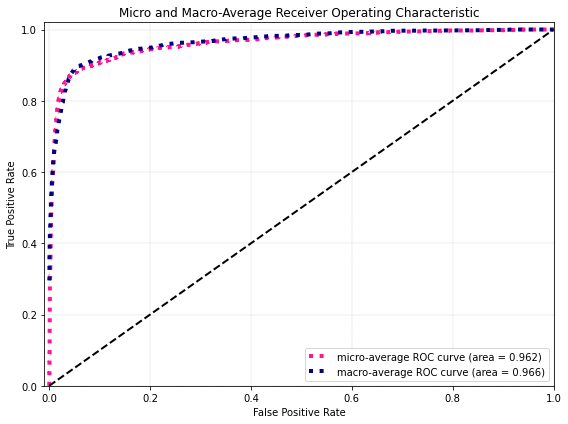

In [53]:
plot_roc_curve(labels_XG_SVD, final_results_XG_SVD, number_classes)

## XFB - RF

In [39]:
performance_XG_RF = calculate_performance_metrics(labels_XG_RF , prediction_XG_RF, number_classes)
print(performance_XG_RF)

      Class  Precision    Recall  F1-Score
0       ACB   0.130000  0.135417  0.132653
1       ASW   0.088889  0.065574  0.075472
2       BEB   0.130435  0.104651  0.116129
3       CDX   0.151515  0.107527  0.125786
4       CEU   0.130435  0.090909  0.107143
5       CHB   0.123810  0.126214  0.125000
6       CHS   0.184874  0.209524  0.196429
7       CLM   0.060000  0.031915  0.041667
8       ESN   0.175258  0.171717  0.173469
9       FIN   0.086957  0.060606  0.071429
10      GBR   0.043478  0.021978  0.029197
11      GIH   0.082645  0.097087  0.089286
12      GWD   0.160000  0.141593  0.150235
13      IBS   0.152709  0.289720  0.200000
14      ITU   0.129032  0.117647  0.123077
15      JPT   0.168224  0.346154  0.226415
16      KHV   0.185185  0.151515  0.166667
17      LWK   0.145985  0.202020  0.169492
18      MSL   0.086420  0.082353  0.084337
19      MXL   0.037037  0.015625  0.021978
20      PEL   0.205128  0.188235  0.196319
21      PJL   0.103175  0.135417  0.117117
22      PUR

/tmp/ipykernel_25893/2900125027.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


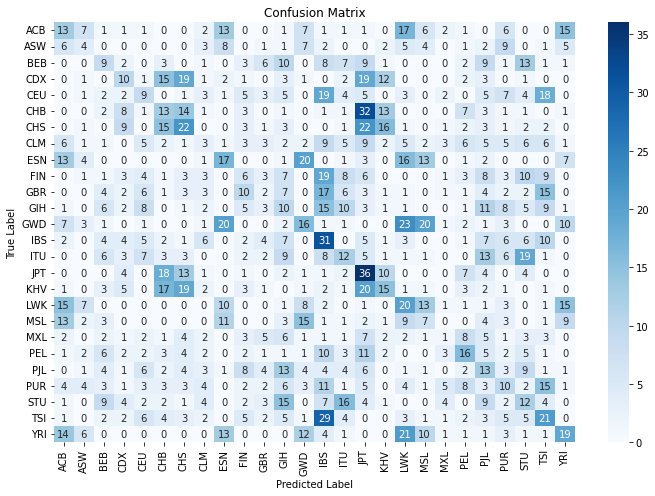

In [61]:
plot_confusion_matrix(labels_XG_RF , prediction_XG_RF, number_classes)

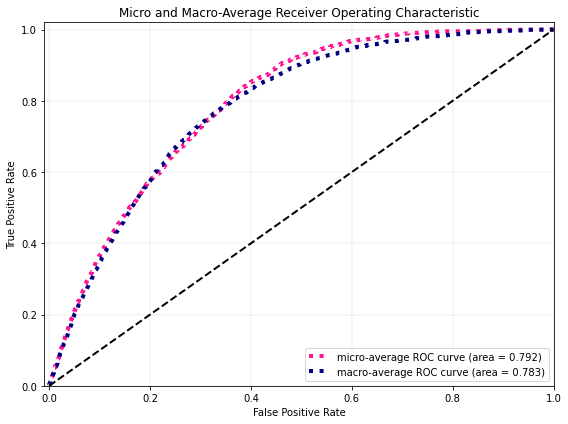

In [54]:
plot_roc_curve(labels_XG_RF, final_results_XG_RF, number_classes)